# Exploring the Capabilities of the STMicroelectonics Sensor Tile

<div style="text-align: center; ">
<figure>
  <img src="img/sensor_tile.png" alt="STEVAL-STWINKT1" style="background:none; border:none; box-shadow:none; text-align:center" width="400px"/>
</figure>
</div>

## Sensing Elements
The STEVAL-STWINKT1 sensor tile contains nine sensing elements (as shown in the figure below):

* **Vibrometer (IIS3DWB)**: Max Sampling Freq = 26.667 kHz
* **3D Accelerometer (IIS2DH)**: Max Sampling Freq = 1344 Hz
* **6-Axis Inertial-Measurement-Unit (ISM330DHCX)**: Max Sampling Freq = 6667 Hz
* **Humidity and Temperature (HTS221)**: Max Sampling Freq = 12.5 Hz
* **Temperature (STTS751)**: Max Sampling Freq = 4 Hz
* **Pressure (LPS22HH)**: Max Sampling Freq = 200 Hz, sensor contains both pressure and temperature
* **3D Magnetometer (IIS2MDC)**: Max Sampling Freq = 100 Hz
* **Analog Microphone (MP23ABS1)**: Max Sampling Freq = 192 kHz
* **Digital Microphone (IMP34DT05)**: Max Sampling Freq = 48 kHz, Suitable for vibration monitoring



![sensing elements](img/sensing_elements.png)

## Collecting and Analyzing Data

STMicroelectronics provides [high-speed data-logging firmware](https://www.st.com/en/embedded-software/fp-sns-datalog1.html?ecmp=tt9470_gl_link_feb2019&rt=um&id=UM2621) and an associated Python package for analyzing the data.

I collected data from the fan, as shown in the picture below.

<div style="text-align: center; ">
<figure>
  <img src="img/fan.jpg" alt="fan and sensor tile" style="background:none; border:none; box-shadow:none; text-align:center" width="500px"/>
  <div style="text-align: center; ">
  <figcaption style="color:grey; font-size:smaller"> The fan configuration for collecting data.</figcaption>
  </div>
</figure>
</div>


Import appropriate packages, and if running in Google Colab, download the data and the HSD module.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal, fftpack

import os
import pathlib
from pathlib import Path
import zipfile # for extracting data zip files

# to clear outputs from cells
from IPython.display import clear_output

root_dir = Path.cwd() # set the root directory as a Pathlib path

folder_raw_data = root_dir / 'data/' # raw data folder that holds the .zip .mat files for milling data

In [10]:
# NEED TO RUN THIS IF RUNNING IN GOOGLE COLAB
# if the data folder does not exist, then you are likely
# in a google colab environment. In that case, we will create the 
# data and processed data folders and download the appropriate files
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)# move to raw data folder
    !wget 'https://github.com/tvhahn/High-Speed-Datalog/raw/master/data/STWIN_00020_ls_window_sill.zip'
    !wget 'https://github.com/tvhahn/High-Speed-Datalog/raw/master/data/STWIN_00019_hs_window_sill.zip'
    !wget 'https://github.com/tvhahn/High-Speed-Datalog/raw/master/data/STWIN_00010_shaking.zip'
    
# change directory back to root and download the HSD SDK (sdk.zip)
os.chdir(root_dir)
!wget 'https://github.com/tvhahn/High-Speed-Datalog/raw/master/sdk.zip'
# extract sdk from the zip file
with zipfile.ZipFile('sdk.zip', 'r') as zip_ref:
    zip_ref.extractall() 
    
clear_output(wait=False)

Import the high-speed data-logger package. Set the location of the collected data and unzip the file.

In [11]:
from HSD import HSDatalog as HSD

# extract data from the zip file
with zipfile.ZipFile(folder_raw_data / 'STWIN_00020_ls_window_sill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

Initialize the HSDatalog class

In [3]:
acq_folder = folder_raw_data / 'STWIN_00020_ls_window_sill' # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

HSDatalog allows you to obtain all the information regarding the acquisition and the board that generated it.

In [4]:
active_sensor_list = hsd.getSensorList(only_active=True)

# print information on each sensor
for sens in active_sensor_list:
    sensor_name = sens.name
    sensor = hsd.getSensor(sensor_name)
    print ("Sensor: {}".format(sensor.name))
    
    # can get the capabilities (descriptor) for each sensor
    s_descriptor_list = sensor.sensor_descriptor.sub_sensor_descriptor
    
    # can get configuration of sensor
    s_status_list = sensor.sensor_status.sub_sensor_status
    
    for i, s in enumerate(s_descriptor_list):
        print(f" --> {s.sensor_type} - ODR: {s_status_list[i].odr} , FS: {s_status_list[i].fs} , SamplesPerTs {s_status_list[i].samples_per_ts} , Unit: {s.unit}")

Sensor: IIS3DWB
 --> ACC - ODR: 26667.0 , FS: 16.0 , SamplesPerTs 1000 , Unit: g
Sensor: HTS221
 --> TEMP - ODR: 12.5 , FS: 120.0 , SamplesPerTs 50 , Unit: Celsius
 --> HUM - ODR: 12.5 , FS: 100.0 , SamplesPerTs 50 , Unit: %
Sensor: IIS2DH
 --> ACC - ODR: 1344.0 , FS: 16.0 , SamplesPerTs 1000 , Unit: g
Sensor: IIS2MDC
 --> MAG - ODR: 100.0 , FS: 50.0 , SamplesPerTs 100 , Unit: gauss
Sensor: IMP34DT05
 --> MIC - ODR: 48000.0 , FS: 122.5 , SamplesPerTs 1000 , Unit: Waveform
Sensor: ISM330DHCX
 --> ACC - ODR: 6667.0 , FS: 16.0 , SamplesPerTs 1000 , Unit: g
 --> GYRO - ODR: 6667.0 , FS: 4000.0 , SamplesPerTs 1000 , Unit: mdps
Sensor: LPS22HH
 --> PRESS - ODR: 200.0 , FS: 1260.0 , SamplesPerTs 200 , Unit: hPa
 --> TEMP - ODR: 200.0 , FS: 85.0 , SamplesPerTs 200 , Unit: Celsius
Sensor: MP23ABS1
 --> MIC - ODR: 192000.0 , FS: 130.0 , SamplesPerTs 1000 , Unit: Waveform
Sensor: STTS751
 --> TEMP - ODR: 4.0 , FS: 100.0 , SamplesPerTs 20 , Unit: Celsius


We can also get the list of sensor data files in your selected acquisition folder:

In [5]:
file_names = hsd.getDataFileList()
print(file_names)

['HTS221_TEMP.dat', 'LPS22HH_PRESS.dat', 'IIS2DH_ACC.dat', 'ISM330DHCX_GYRO.dat', 'IIS3DWB_ACC.dat', 'LPS22HH_TEMP.dat', 'IMP34DT05_MIC.dat', 'STTS751_TEMP.dat', 'ISM330DHCX_ACC.dat', 'MP23ABS1_MIC.dat', 'HTS221_HUM.dat', 'IIS2MDC_MAG.dat']


## Fast-Fourier Transform Low-Speed Data
We will get an FFT of the z-axis acceleration for the fan running at low speed. I collected data for about 2 minutes.

In [6]:
# extract data from the zip file
with zipfile.ZipFile(folder_raw_data / 'STWIN_00020_ls_window_sill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

# load the data
acq_folder = folder_raw_data / 'STWIN_00020_ls_window_sill' # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

# select the sensor
sensor_name = "IIS3DWB"
sensor_type = "ACC"

# HSD method for extracting info into pandas dataframe
df = hsd.get_dataFrame(sensor_name, sensor_type)
print('Duration (s):', df['Time'].iloc[-1])
df.head()

Duration (s): 127.78190402498174


,Time,A_x [g],A_y [g],A_z [g]
0,0.140083,-0.054656,-0.118584,1.095072
1,0.140121,-0.081496,-0.121024,1.084336
2,0.140158,-0.070272,-0.113216,1.103368
3,0.140196,-0.053192,-0.111752,1.088240
4,0.140234,-0.067832,-0.135664,1.131184


Before applying the FFT, we will first detrend and then window the signal. This is how:

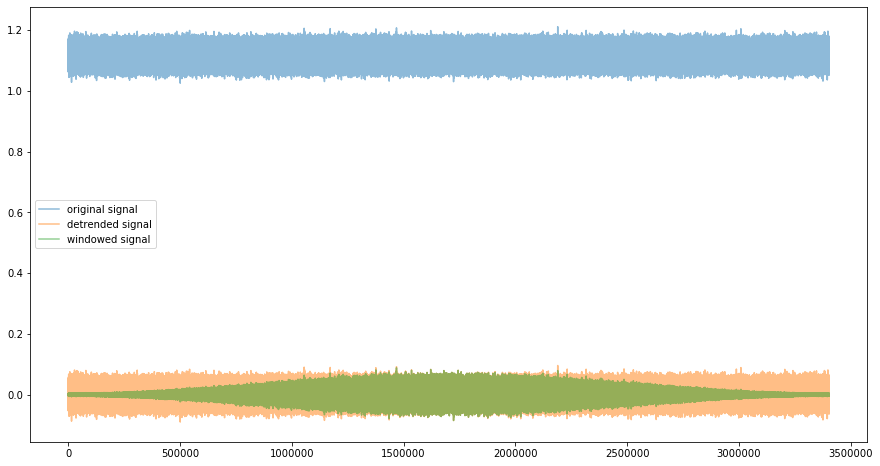

In [7]:
# practice detrending
fig, axes = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['A_z [g]'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['A_z [g]'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
y_detrend *= np.hamming(len(y_detrend))
# y_detrend *= np.kaiser(len(y_detrend), 8)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

Create a generic function for plotting the FFT.

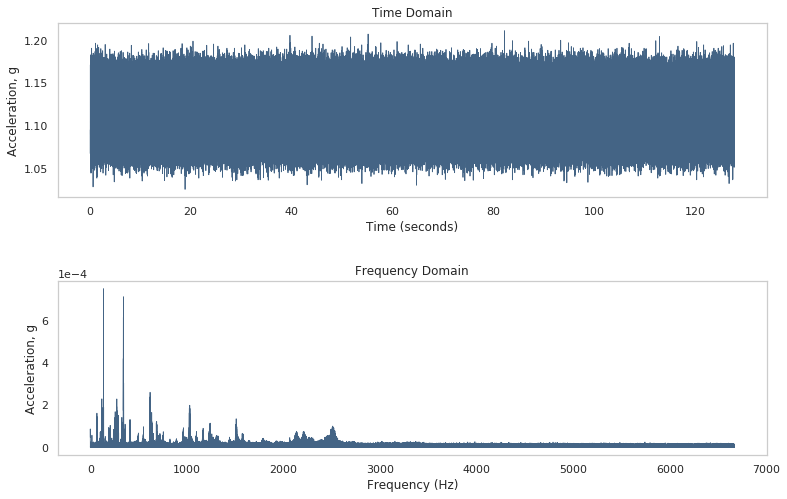

In [8]:
def create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True, window='hamming', beta=8):
    '''Create FFT plot from a pandas dataframe'''

    y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    x = df[x_name].to_numpy(dtype="float64")

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points
    
    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal
    
    if window == 'hamming':
        y_detrend *= np.hamming(N)  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    else:
        y_detrend *= np.kaiser(len(y_detrend), beta)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)/2

    if show_plot:
        # setup the seaborn plot
        sns.set(font_scale=1.0, style="whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
        fig.tight_layout(pad=5.0)

        pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

        # plot time domain signal
        axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
        axes[0].set_xlabel("Time (seconds)")
        axes[0].set_ylabel("Acceleration, g")
        # axes[0].set_yticklabels([])

        # plot the frequency domain signal
        axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Acceleration, g")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        

        # clean up the sub-plots to make everything pretty
        for ax in axes.flatten():
            ax.yaxis.set_tick_params(labelleft=True, which="major")
            ax.grid(False)
            
        # in case you want to save the figure (just uncomment)
        # plt.savefig('time_freq_domains.svg',dpi=600,bbox_inches = "tight")
        plt.show()
    
    return xf, yf


xf, yf = create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True, window='hamming')

It looks like, from the above frequency domain plot, that we have a number of frequency peaks, along with a number of additional side bands. Let's zoom in.

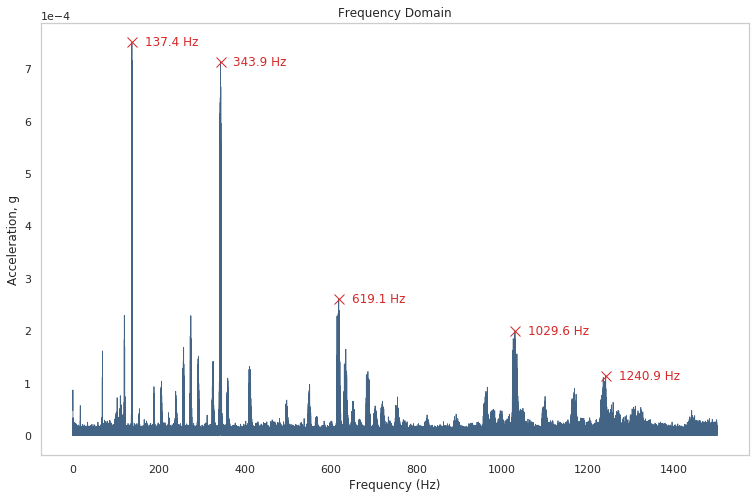

In [9]:
def plot_freq(xf, yf, max_freq_to_plot=1000, peak_height=0.0001, peak_distance=100):

    # select the index number where xf is less than a certain freq
    i = np.where(xf<max_freq_to_plot)[0][-1]
    peak_distance_index = peak_distance * i / max_freq_to_plot

    # setup the seaborn plot
    sns.set(font_scale=1.0, style="whitegrid")
    fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=False, sharey=False)
    fig.tight_layout(pad=5.0)
    
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

    # plot the frequency domain signal
    axes.plot(xf[:i], yf[:i], marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes.set_title("Frequency Domain", fontdict={"fontweight": "normal"})
    axes.set_xlabel("Frequency (Hz)")
    axes.set_ylabel("Acceleration, g")
    axes.yaxis.set_tick_params(labelleft=True, which="major")
    axes.grid(False)

    peaks, _ = signal.find_peaks(yf[:i], height=peak_height, distance=peak_distance_index)
    plt.plot(xf[peaks], yf[peaks], "x", color='#d62728', markersize=10)

    for p in peaks:
        axes.text(
            x=xf[p]+max_freq_to_plot/50.0,
            y=yf[p],
            s=f"{xf[p]:.1f} Hz",
            horizontalalignment="left",
            verticalalignment="center",
            size=12,
            color="#d62728",
            rotation="horizontal",
            weight="normal",
        )

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show()


plot_freq(xf, yf, max_freq_to_plot=1500, peak_height=0.0001, peak_distance=100)

It's tough to say what all of the peaks represents. Here is what we know:

* The operating speed of the fan, according to the technical documentation, is 1300 RMP (21.7 Hz). However, the documentation does not state if the 1300 RPM is for the low, medium, or high speed.
* The fan has 7 blades. 7 x 21.7 = 147, which is close to the 137.4 Hz on the plot. Therefore, the blade pass frequency is likely 137.4 Hz.

Based on these deductions, the **rotational speed of the fan at low speed is likely 19.6 Hz**.

There are two small bearings in the fan. Some of the peaks and their sidebands are likely related to the ball-pass frequencies.

## Fast-Fourier Transform High-Speed Data
Now let's see how that changes when the fan is running at a "high" speed.

Duration (s): 129.5019510237779


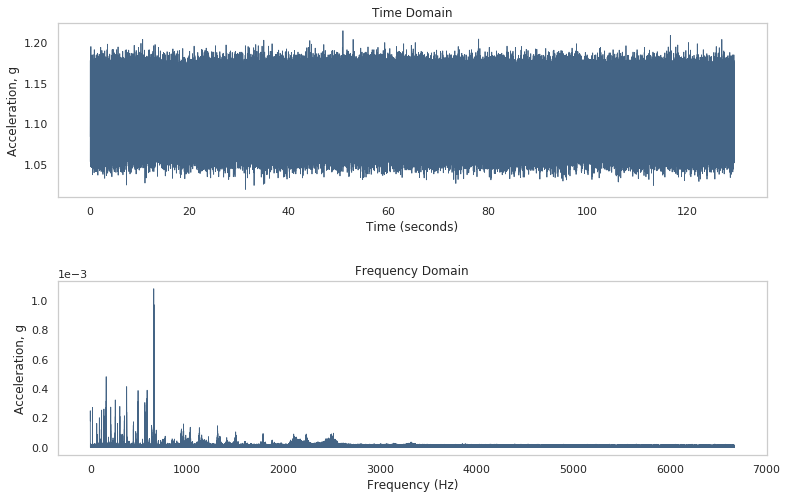

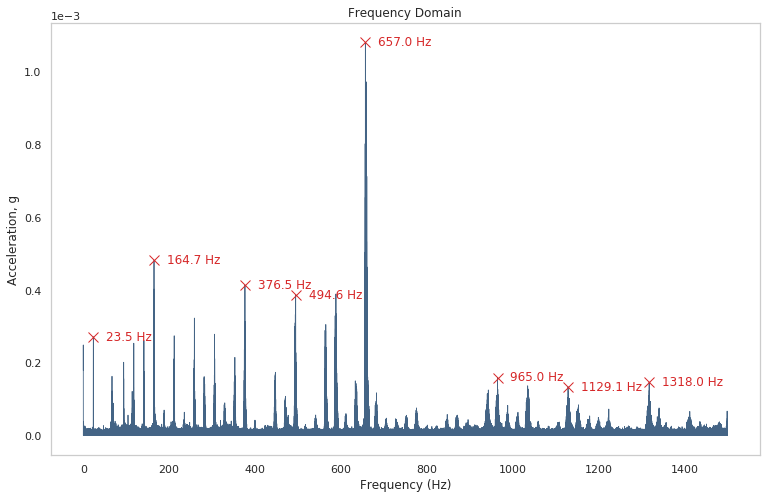

In [10]:
# extract data from the zip file
with zipfile.ZipFile(folder_raw_data / 'STWIN_00019_hs_window_sill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

# load the data
acq_folder = folder_raw_data / 'STWIN_00019_hs_window_sill' # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

sensor_name = "IIS3DWB"
sensor_type = "ACC"

# HSD method for extracting info into pandas dataframe
df = hsd.get_dataFrame(sensor_name, sensor_type)
print('Duration (s):', df['Time'].iloc[-1])

xf, yf = create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True, window='hamming', beta=0)

plot_freq(xf, yf, max_freq_to_plot=1500, peak_height=0.000125,peak_distance=100)

The 164.7 Hz likely relates to the **rotational speed of the fan at high speed of 23.5 Hz**.

Most interesting is the large spike at 657 Hz. My guess is that this relates to some sort of natural frequency of the system.

## Fast-Fourier Transform when Shaking Sensor Tile
Now lets look at the data from when we were shaking the senor tile up and down (give the sensor a shake about every second or so)

Duration (s): 15.235172370633332


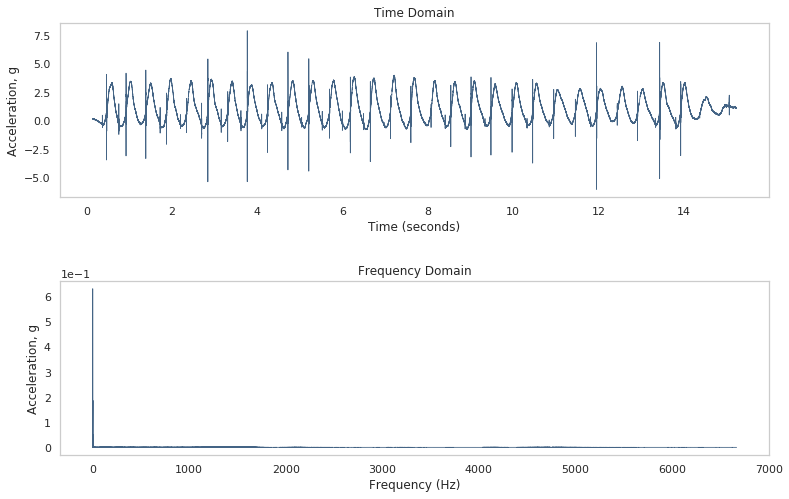

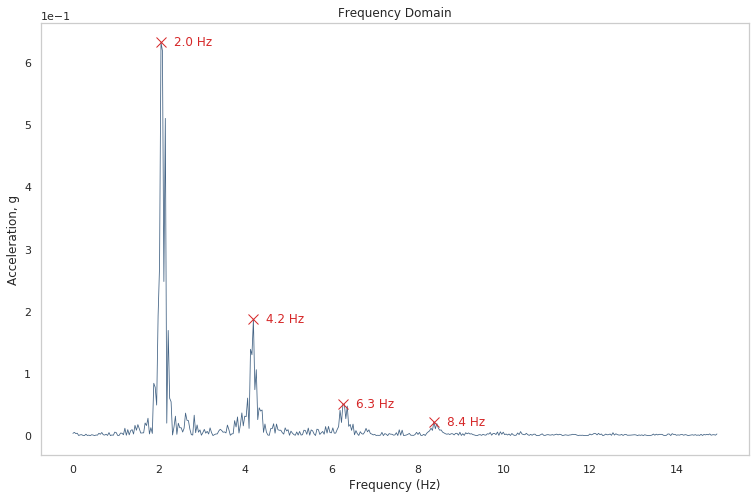

In [11]:
# extract data from the zip file
with zipfile.ZipFile(folder_raw_data / 'STWIN_00010_shaking.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

# load the data
acq_folder = folder_raw_data / 'STWIN_00010_shaking' # this is for the fan at low speed
hsd = HSD.HSDatalog(acquisition_folder=acq_folder)

sensor_name = "IIS3DWB"
sensor_type = "ACC"

# HSD method for extracting info into pandas dataframe
df = hsd.get_dataFrame(sensor_name, sensor_type)
print('Duration (s):', df['Time'].iloc[-1])

xf, yf = create_fft(df, x_name='Time', y_name='A_z [g]', sample_freq=26667.0, show_plot=True, window='hamming', beta=0)

plot_freq(xf, yf, max_freq_to_plot=15, peak_height=0.02,peak_distance=1.2)

Sure enough, I was shaking the sensor tile at about 2 Hz. The harmonics of this, in my estimation, are due to the lack of rigidity in the system. The screws on the sensor tile where not 100% tight, and the battery in the sensor tile case can "clack" around.

## Other Visualizations
The HSDatalog also has some built in methods for quickly visualizing the data (but we will build our own too).

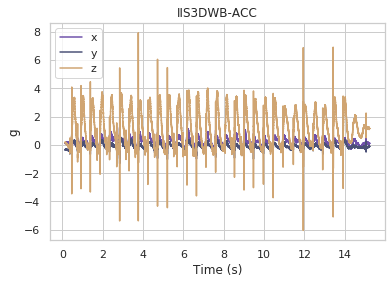

In [12]:
hsd.get_sensorPlot(sensor_name, sensor_type)

We can plot all the sensors the same way.

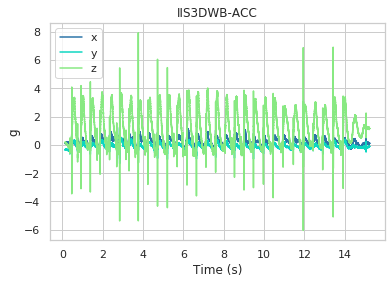

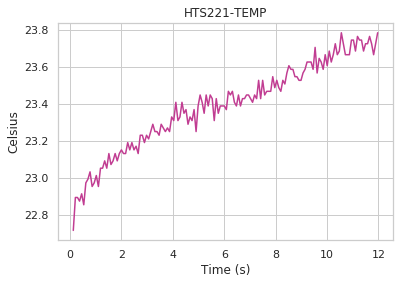

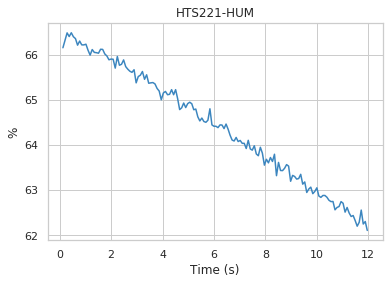

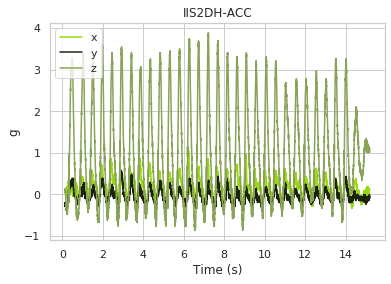

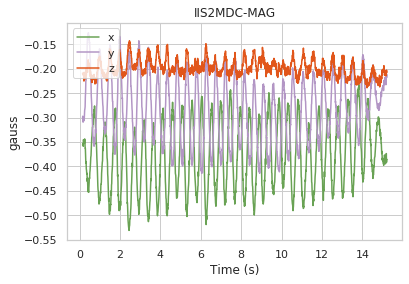

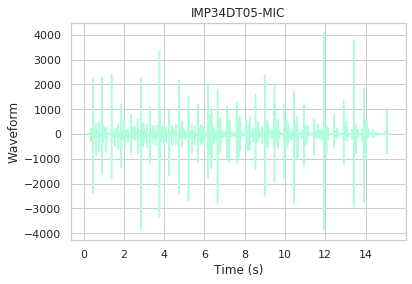

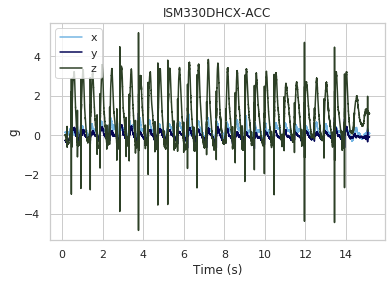

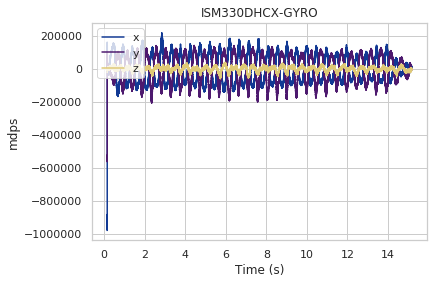

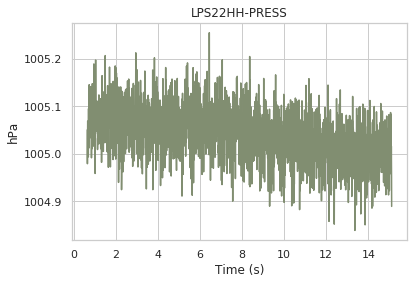

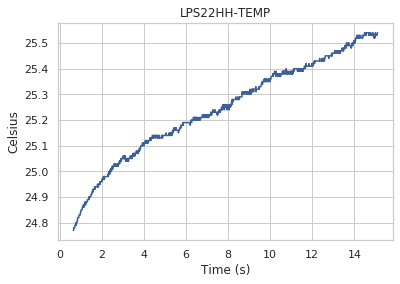

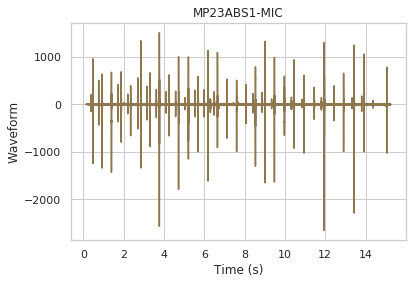

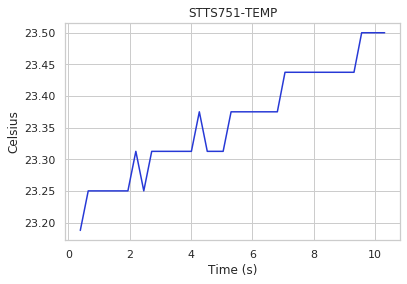

In [13]:
active_sensor_list = hsd.getSensorList(only_active=True)

plots = []
for s in active_sensor_list:
    for ssd in s.sensor_descriptor.sub_sensor_descriptor:
        hsd.get_sensorPlot(s.name, ssd.sensor_type)